<a href="https://colab.research.google.com/github/karenwhite33/Llama3_python_like_a_pro_ASSISTANT/blob/main/2_config__dataset_finetune_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting Up the AI Coding Assistant Phyton Like A Pro**

1️⃣ Crear una Carpeta para el Proyecto en Visual Studio Code

In [ ]:
local-ai-code-assistant


2️⃣ Crear un Entorno Virtual para el Proyecto
Para evitar conflictos con otras librerías de Python.

In [ ]:
python -m venv venv


In [ ]:
venv\\Scripts\\activate


3️⃣ Instalar dependencias iniciales


In [ ]:
pip install torch transformers datasets typer ollama


📌 Explicación de los paquetes instalados:

torch → Para manejar modelos de deep learning.

transformers → Para trabajar con CodeLlama 7B y otros modelos.

datasets → Para cargar el dataset CodeSearchNet desde Hugging Face.

typer → Para crear la interfaz de línea de comandos del asistente.

ollama → Para gestionar modelos LLM de forma local.

4️⃣ Crear requirements.txt

In [ ]:
pip freeze > requirements.txt


5️⃣ Instalar y configurar Ollama para ejecutar modelos localmente.


In [ ]:
ollama list


📌 Agregar Ollama al PATH de windows
Para que Windows pueda reconocer ollama en la terminal, hay que agregar su ubicación a las variables de entorno:

In [ ]:
C:\Users\kshad\AppData\Local\Programs\Ollama


📌 Verificar Instalación

In [ ]:
ollama list


7️⃣ Descargar y Probar CodeLlama 7B
Ejecuta el siguiente comando en la terminal de VS Code para descargar el modelo:

In [ ]:
ollama pull codellama:7b


8️⃣ Verificar que CodeLlama 7B Funciona
Cuando la descarga termine, ejecuta este comando para probar el modelo:

In [ ]:
ollama run codellama:7b


Si todo está bien, el modelo se cargará y esperará un prompt. Puedes escribir algo como:

In [ ]:
Write a Python function that sorts a list.


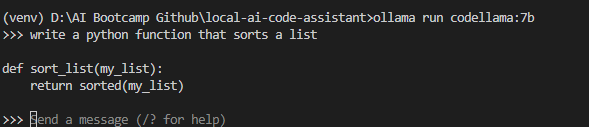

9️⃣ **Cargar y Preprocesar el Dataset CodeSearchNet**

In [ ]:
python -c "from datasets import load_dataset; dataset = load_dataset('code-search-net/code_search_net'); print(dataset)"


In [ ]:
python load_dataset.py


📌 **Preprocesar el Dataset**


El dataset contiene varias columnas, pero para generación de código, solo interesan estas dos:

func_documentation_string → La descripción en lenguaje natural de la función.

func_code_string → El código correspondiente a esa descripción.

Extraeré solo estas columnas y me aseguraré de que no haya valores vacíos o datos corruptos.

In [ ]:
from datasets import load_dataset

# Cargar el dataset
dataset = load_dataset("code-search-net/code_search_net", trust_remote_code=True)

# Seleccionar solo las columnas necesarias
columns_to_keep = ["func_documentation_string", "func_code_string"]

# Filtrar el dataset para solo mantener Python y eliminar nulos
def filter_and_clean(example):
    return example["language"] == "python" and example["func_documentation_string"] and example["func_code_string"]

filtered_dataset = dataset.filter(filter_and_clean)

# Mostrar algunas muestras del dataset procesado
print(filtered_dataset["train"][0])
print(filtered_dataset["train"][1])
print(f"Total muestras después del filtrado: {len(filtered_dataset['train'])}")

# Guardar el dataset procesado en un formato optimizado (parquet)
filtered_dataset.save_to_disk("processed_dataset")


## **Apply Prompt structure**

In [ ]:
from datasets import load_from_disk, DatasetDict
import os

# Cargar el dataset procesado
dataset = load_from_disk("processed_dataset")

# Mensaje del sistema optimizado (versión final aceptada)
system_message = (
    "You are a Senior Software Developer and a helpful AI programming assistant. "
    "Generate only Python code without explanations. Respond only in English."
)

# Función para construir el prompt estructurado (versión final)
def prompt_template(instruction, code=""):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += system_message + "\n\n"
    full_prompt += "### Task:\n"
    full_prompt += instruction + "\n\n"
    full_prompt += "### Response:\n"
    if code:
        full_prompt += code
    full_prompt += "\n<|endoftext|>"

    return full_prompt

# Aplicar el prompt estructurado al dataset
def format_dataset(example):
    instruction = example["func_documentation_string"]
    code = example.get("func_code_string", "")
    example["formatted_prompt"] = prompt_template(instruction, code)
    return example

formatted_dataset = dataset.map(format_dataset)

# Guardar el nuevo dataset con los prompts aplicados
output_dir = "formatted_dataset"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

formatted_dataset.save_to_disk(output_dir)

print(f"✅ Dataset con prompts aplicado y guardado en '{output_dir}'")


## **Filtrar dataset a 10000 muestras**

In [ ]:
from datasets import load_from_disk, DatasetDict

# Cargar dataset tokenizado completo
dataset = load_from_disk("formatted_dataset")

# Filtrar el conjunto de entrenamiento a 10,000 muestras
train_dataset = dataset["train"].shuffle(seed=42).select(range(10_000))

# Ajustar validación y test al 10% de train
validation_dataset = dataset["validation"].shuffle(seed=42).select(range(1_000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(1_000))

# Crear nuevo dataset balanceado
balanced_dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
    "test": test_dataset
})

# Guardar el dataset corregido
balanced_dataset.save_to_disk("formatted_dataset_10000")

print("✅ Dataset filtrado correctamente y guardado como 'formatted_dataset_10000'.")


### **Tokenizar dataset**

In [ ]:
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer

# Cargar el dataset formateado con apply_prompt
formatted_dataset_path = "formatted_dataset_10000"
dataset = load_from_disk(formatted_dataset_path)

# Cargar el tokenizador del modelo correcto
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)

# Asignar token de padding
tokenizer.pad_token = tokenizer.eos_token

# Función de tokenización con etiquetas (labels)
def tokenize_function(examples):
    model_inputs = tokenizer(
        examples["formatted_prompt"],  # ✅ Se tokeniza el texto ya formateado con apply_prompt
        padding="max_length",
        truncation=True,
        max_length=512
    )

    # ✅ Agregar etiquetas (labels) para el entrenamiento
    model_inputs["labels"] = model_inputs["input_ids"].copy()

    return model_inputs

# Aplicar la tokenización
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Guardar el dataset tokenizado
tokenized_dataset.save_to_disk("tok_dataset_10000")

print("✅ Dataset tokenizado con labels y guardado en 'tok_dataset_10000")

## ❌ ❌ **El fine-tuning en local fue imposible de hacer por recursos inclusive dejando el dataset con solo 5000 muestras, se demoría semanas en entrenar y por eso he decidido hacer el Fine-tuning en collab con la T4 y 10000 muestras.**

### ***He cambiado tambien de modelo al Llama-3.2-1B-Instruct por eficiencia en CPU, CodeLlama 7B era mas pesado para finetunear***

# **Descarga y carga del dataset en Collab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("❌ No hay GPU disponible")


❌ No hay GPU disponible


In [ ]:
import shutil

# Descomprimir el dataset en la ubicación correcta
shutil.unpack_archive("/content/drive/MyDrive/local-ai-code-assistant/tok_dataset_10000_colab.zip", "/content/drive/MyDrive/local-ai-code-assistant/tok_dataset_10000_colab")

print("✅ Dataset descomprimido correctamente.")


✅ Dataset descomprimido correctamente.


## **MODIFICAR EL DATASET PARA INCLUIR PROMPTS ESTRUCTURADOS**

**Prompt preparation**


These functions format data into structured prompts for language model training or evaluation. **prompt_template** constructs a text block with predefined instructions, user input as context, and a response if available.

**create_prompt** processes a data sample, extracting instruction and response, and uses **prompt_template** to format them. This setup is useful for training conversational AI, ensuring consistent data presentation.

In [ ]:
# Definir el mensaje del sistema
system_message = (
    "You are a Senior Software Developer and a helpful AI programming assistant. "
    "Follow the user's requirements carefully and generate high-quality Python code. "
    "1. Think step-by-step: First, describe your plan in pseudocode. "
    "2. Generate code: Write the Python code in a single block. "
    "3. Minimize prose: Keep explanations concise. "
    "4. Always respond in English."
)

# Función para crear el prompt estructurado
def prompt_template(instruction, code=""):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += system_message + "\n\n"
    full_prompt += "### Task:\n"
    full_prompt += instruction + "\n\n"
    full_prompt += "### Response:\n"
    if code:
        full_prompt += code
    full_prompt += "\n<|endoftext|>"

    return full_prompt

# Función para aplicar el formato al dataset
def create_prompt(sample):
    instruction = sample["func_documentation_string"]  # Corrección de clave
    code = sample.get("func_code_string", "")  # Usar .get() para evitar errores si no hay respuesta

    return prompt_template(instruction, code)

# Test ejemplo del dataset
dataset = {
    "train": [
        {
            "func_documentation_string": "Write a Python function to calculate the sum of elements in a list.",
            "func_code_string": ""
        }
    ]
}

# Crear el prompt de prueba
prompt = create_prompt(dataset["train"][0])

print("Generated Prompt:")
print(prompt)


## **Función de inferencia**

In [ ]:
import torch

# Función para generar respuestas con el modelo
def generate_response(prompt, model, tokenizer, max_tokens=256, temperature=0.7, top_p=0.9):
    # Tokenizar la entrada
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True, padding=True, truncation=True, max_length=512)

    # Mover entrada a GPU si está disponible
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_inputs = {key: value.to(device) for key, value in encoded_input.items()}

    # Generar respuesta con sampling controlado
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_tokens,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decodificar la respuesta
    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Recortar respuesta redundante si es necesario
    response_start = decoded_output.find("### Response")
    if response_start != -1:
        decoded_output = decoded_output[response_start + len("### Response"):].strip()

    return decoded_output



# **Testeando prompt y response antes de fine tunear**

In [ ]:
!pip install transformers accelerate torch


### **Cargar el modelo con cuantización INT4**
INT4 con BitsAndBytes para que reduzca el uso de memoria y mejorar la inferencia.


In [ ]:
from huggingface_hub import login
login()

In [ ]:
!pip uninstall -y bitsandbytes
!pip install bitsandbytes --no-cache-dir
!pip install --upgrade --force-reinstall --no-cache-dir torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install -U bitsandbytes

In [ ]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import torch

# Configurar cuantización INT4
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Cargar modelo en 4-bit para reducir memoria
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # Cuantización NF4 (más eficiente)
    bnb_4bit_compute_dtype=torch.float16  # Computación en FP16
)

# Nombre del modelo
model_name = "meta-llama/Llama-3.2-1B-Instruct"

# Cargar modelo en INT4
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,  # Aplicar INT4
    device_map="auto"  # Asignar automáticamente GPU/CPU
)

# Cargar el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Asegurar token de padding

print("✅ Modelo en INT4 cargado correctamente.")

# Verificar si el modelo realmente está en INT4
print(model.hf_device_map)  # Ver en qué dispositivo está (CPU/GPU)
print(model.config)  # Revisar configuración del modelo


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

✅ Modelo en INT4 cargado correctamente.
{'': 0}
LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B-Instruct",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": [
    128001,
    128008,
    128009
  ],
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Mover el modelo a la GPU o CPU


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-0

## **Prompt template + función de inferencia**

In [ ]:
# Definir el mensaje del sistema
system_message = (
    "You are a Senior Software Developer and a helpful AI programming assistant. "
    "Follow the user's requirements carefully and generate high-quality Python code. "
    "1. Think step-by-step: First, describe your plan in pseudocode. "
    "2. Generate code: Write the Python code in a single block. "
    "3. Minimize prose: Keep explanations concise. "
    "4. Always respond in English."
)

# Función para crear el prompt estructurado
def prompt_template(instruction, code=""):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += system_message + "\n\n"
    full_prompt += "### Task:\n"
    full_prompt += instruction + "\n\n"
    full_prompt += "### Response:\n"
    if code:
        full_prompt += code
    full_prompt += "\n<|endoftext|>"

    return full_prompt

# Prueba con un ejemplo del dataset
instruction = "Write a Python function to calculate the sum of elements in a list."
prompt = prompt_template(instruction)

print("Generated Prompt:")
print(prompt)

# Función para probar la inferencia con el modelo base
def generate_response(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True)
    model_inputs = encoded_input.to(device)

    generated_ids = model.generate(**model_inputs, max_new_tokens=256, do_sample=True, pad_token_id=tokenizer.eos_token_id)

    decoded_output = tokenizer.batch_decode(generated_ids)

    return decoded_output[0].replace(prompt, "").strip()

# Generar respuesta con el modelo base
response = generate_response(prompt, model, tokenizer)

print("📝 Código generado:\n")
print(response)


Generated Prompt:
<|startoftext|>
### Instruction:
You are a Senior Software Developer and a helpful AI programming assistant. Follow the user's requirements carefully and generate high-quality Python code. 1. Think step-by-step: First, describe your plan in pseudocode. 2. Generate code: Write the Python code in a single block. 3. Minimize prose: Keep explanations concise. 4. Always respond in English.

### Task:
Write a Python function to calculate the sum of elements in a list.

### Response:

<|endoftext|>
📝 Código generado:

<|begin_of_text|> 
### Pseudocode:
- Define the input list
- Initialize a variable to store the sum
- Iterate through the list
- Add each element to the sum

### Python Code:
```python
def calculate_sum(input_list):
    # Initialize the sum variable
    total_sum = 0
    
    # Iterate through the list
    for element in input_list:
        # Add each element to the sum
        total_sum += element
    
    # Return the calculated sum
    return total_sum

# Ex

📌 **Evaluación de la respuesta**

👌 La generación en Colab tardó 10 segs y generó la siguiente salida:


La respuesta tiene la estructura esperada: pseudocódigo + código Python + explicación.

El código generado es correcto y funcional.

Sigue la instrucción de escribir una función en Python para sumar los elementos de una lista.

Genera un ejemplo de uso (numbers = [1, 2, 3, 4, 5]).

Utiliza docstrings bien estructurados en la función.


❌ Puntos a mejorar:

Explicación innecesaria:

Aunque el código es bueno, está incluyendo explicaciones demasiado largas.
Queremos solo el código → Esto se corrige ajustando el system_message y los parámetros de inferencia.


## **Prompt template e Inferencia optimizada**

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Asegurar que estamos usando GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Modelo se ejecutará en: {device}")

# Modelo a utilizar (asegúrate de tener acceso en Hugging Face)
model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
tokenizer.pad_token = tokenizer.eos_token  # Asignar token de padding

# Cargar el modelo en GPU con optimización en INT4
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
print("✅ Modelo cargado correctamente.")

# System message optimizado
system_message = (
    "You are a Senior Software Developer and a helpful AI programming assistant. "
    "Generate only Python code without explanations. Respond only in English."
)

# Función para construir el prompt
def prompt_template(instruction, code=""):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += system_message + "\n\n"
    full_prompt += "### Task:\n"
    full_prompt += instruction + "\n\n"
    full_prompt += "### Response:\n"
    if code:
        full_prompt += code
    full_prompt += "\n<|endoftext|>"

    return full_prompt

# Ejemplo de prueba
instruction = "Write a Python function to calculate the sum of elements in a list."
prompt = prompt_template(instruction)

# Función de inferencia optimizada
def generate_code(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(device)

    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=512,  # Suficiente para respuestas largas
        do_sample=False,  # Evita respuestas aleatorias
        temperature=0,  # Respuesta determinista
        pad_token_id=tokenizer.eos_token_id
    )

    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_output[0].replace(prompt, "").strip()

# Generar código
response = generate_code(prompt, model, tokenizer)

# Mostrar resultado
print("📝 Código generado:\n")
print(response)


✅ Modelo se ejecutará en: cuda
✅ Modelo cargado correctamente.


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


📝 Código generado:

def sum_list(lst):
    return sum(lst)


# **Respuesta al punto con esta optimización-algunos warnings**

100% determinista, siempre devuelve la misma respuesta para el mismo prompt  

    **temp en 0**

Más preciso, sigue el patrón más probable en los datos de entrenamiento.

Menos creatividad, pero más fiabilidad en aplicaciones críticas.

## ⭐ **Quiero agregar un poco mas de variabilidad a la respuesta, usaré:**

    **temp en 0.7**

    **top_p en 0.9**

Más variabilidad en la respuesta.

Puede producir múltiples formas de expresar la solución.

Respuestas creativas o alternativas.

## **Prompt template + inferencia final**

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Asegurar que estamos usando GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Modelo se ejecutará en: {device}")

# Modelo a utilizar (asegúrate de tener acceso en Hugging Face)
model_name = "meta-llama/Llama-3.2-1B-Instruct"

# Cargar el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
tokenizer.pad_token = tokenizer.eos_token  # Asignar token de padding

# Cargar el modelo en GPU con optimización en INT4
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
print("✅ Modelo cargado correctamente.")

# System Message optimizado
system_message = (
    "You are a Senior Software Developer and a helpful AI programming assistant. "
    "Generate only Python code without explanations. Respond only in English."
)

# Función para construir el prompt
def prompt_template(instruction, code=""):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += system_message + "\n\n"
    full_prompt += "### Task:\n"
    full_prompt += instruction + "\n\n"
    full_prompt += "### Response:\n"
    if code:
        full_prompt += code
    full_prompt += "\n<|endoftext|>"

    return full_prompt

# Ejemplo de prueba
instruction = "Write a Python function to calculate the sum of elements in a list."
prompt = prompt_template(instruction)

# Función de inferencia optimizada
def generate_code(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(device)

    generated_ids = model.generate(
    **encoded_input,
    max_new_tokens=512,
    do_sample=True,  # Activa muestreo
    temperature=0.7,  # Controla la aleatoriedad (baja = respuestas más seguras)
    top_p=0.9,  # Mantiene las palabras con probabilidad más alta
    pad_token_id=tokenizer.eos_token_id
)

    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_output[0].replace(prompt, "").strip()

# Generar código
response = generate_code(prompt, model, tokenizer)

# Mostrar resultado
print("📝 Código generado:\n")
print(response)


✅ Modelo se ejecutará en: cuda
✅ Modelo cargado correctamente.
📝 Código generado:

def sum_list_elements(lst):
    return sum(lst)


# **Aplicar Prompt Template todo el dataset**

In [ ]:
from datasets import load_from_disk, DatasetDict
import os

# ✅ Cargar el dataset procesado
dataset = load_from_disk("processed_dataset")

# ✅ Mensaje del sistema optimizado (versión final aceptada)
system_message = (
    "You are a Senior Software Developer and a helpful AI programming assistant. "
    "Generate only Python code without explanations. Respond only in English."
)

# ✅ Función para construir el prompt estructurado (versión final)
def prompt_template(instruction, code=""):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += system_message + "\n\n"
    full_prompt += "### Task:\n"
    full_prompt += instruction + "\n\n"
    full_prompt += "### Response:\n"
    if code:
        full_prompt += code
    full_prompt += "\n<|endoftext|>"

    return full_prompt

# ✅ Aplicar el prompt estructurado al dataset
def format_dataset(example):
    instruction = example["func_documentation_string"]
    code = example.get("func_code_string", "")
    example["formatted_prompt"] = prompt_template(instruction, code)
    return example

formatted_dataset = dataset.map(format_dataset)

# ✅ Guardar el nuevo dataset con los prompts aplicados
output_dir = "formatted_dataset"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

formatted_dataset.save_to_disk(output_dir)

print(f"✅ Dataset con prompts aplicado y guardado en '{output_dir}'")


# **Fine Tuning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("❌ No hay GPU disponible")

✅ GPU disponible: Tesla T4


In [ ]:
from huggingface_hub import login
login()


In [ ]:
!pip install transformers datasets accelerate peft bitsandbytes -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
%cd /content/drive/MyDrive/local-ai-code-assistant/


/content/drive/.shortcut-targets-by-id/1coghy8ZagaoB5DEJl76T0XPKQNGEEZtU/local-ai-code-assistant


In [ ]:
from datasets import load_from_disk

dataset = load_from_disk("/content/drive/.shortcut-targets-by-id/1coghy8ZagaoB5DEJl76T0XPKQNGEEZtU/local-ai-code-assistant/tok_dataset_10000_colab")
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url', 'formatted_prompt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url', 'formatted_prompt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['repository_name', 'func_path_in_repository', 'func_name', 'whole_func_string', 'language', 'func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'split_name', 'func_code_url', 'formatted_pro

In [ ]:
!pip install tiktoken --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


In [ ]:
!pip install blobfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 20.2 MB/s eta 0:00:00


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_from_disk
from peft import LoraConfig, get_peft_model
import os
from transformers import BitsAndBytesConfig

# Definir la ruta del dataset y checkpoints en Google Drive
dataset_path = "/content/drive/.shortcut-targets-by-id/1coghy8ZagaoB5DEJl76T0XPKQNGEEZtU/local-ai-code-assistant/tok_dataset_10000_colab"
checkpoint_dir = "/content/drive/.shortcut-targets-by-id/1coghy8ZagaoB5DEJl76T0XPKQNGEEZtU/local-ai-code-assistant/tok_dataset_10000_colab/models/finetuned_model"

# Cargar el dataset tokenizado
dataset = load_from_disk(dataset_path)

# Nombre del modelo a utilizar
model_name = "meta-llama/Llama-3.2-1B-Instruct"

# Cargar el tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
tokenizer.pad_token = tokenizer.eos_token  # Usar el token de fin de secuencia como padding

# Verificar si GPU está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Entrenamiento en: {device}")

# Configuración para cargar el modelo en 4-bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Cargar el modelo en GPU con LoRA
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
    device_map="auto"
)

"""
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,  # Cambiar a float32 para CPU
    device_map="cpu"  # Forzar uso de CPU
)
"""

# Configuración de LoRA
config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Aplicar LoRA al modelo
model = get_peft_model(model, config)

# Configurar los argumentos del entrenamiento
training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    save_strategy="steps",
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_total_limit=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    logging_steps=50,
    learning_rate=2e-4,
    weight_decay=0.01,
    num_train_epochs=1,
    fp16=True,
    optim="adamw_torch"
)

# Buscar el último checkpoint en Google Drive (si existe)
if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) > 0:
    last_checkpoint = max([os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir)], key=os.path.getmtime)
    print(f" Reanudando desde el checkpoint: {last_checkpoint}")
else:
    last_checkpoint = None  # No reanudar si no hay checkpoint válido

# Configurar el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer
)

# Iniciar Fine-Tuning (desde el último checkpoint si existe)
if last_checkpoint:
    trainer.train(resume_from_checkpoint=last_checkpoint)
else:
    print("⚠️ No se encontró un checkpoint válido. Iniciando entrenamiento desde cero.")
    trainer.train()

# Guardar el modelo final en Google Drive
trainer.save_model(checkpoint_dir)
print(f"✅ Fine-tuning completado y modelo guardado en {checkpoint_dir}")


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

✅ Entrenamiento en: cuda


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


⚠️ No se encontró un checkpoint válido. Iniciando entrenamiento desde cero.


Step,Training Loss,Validation Loss
100,0.758900,0.819925
200,0.737800,0.812225
300,0.778200,0.806569
400,0.808300,0.804868
500,0.705900,0.800752
600,0.760400,0.800228
700,0.652200,0.799886
800,0.666500,0.798375
900,0.755700,0.797691
1000,0.678800,0.796711


✅ Fine-tuning completado y modelo guardado en /content/drive/.shortcut-targets-by-id/1coghy8ZagaoB5DEJl76T0XPKQNGEEZtU/local-ai-code-assistant/tok_dataset_10000_colab/models/finetuned_model


# 🆙 **Cargar el modelo fine-tuneado**

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Ruta del modelo fine-tuneado
model_path = "/content/drive/.shortcut-targets-by-id/1coghy8ZagaoB5DEJl76T0XPKQNGEEZtU/local-ai-code-assistant/tok_dataset_10000_colab/models/finetuned_model"

# Cargar el tokenizador y el modelo
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16, device_map="auto")

# Mover a GPU si está disponible
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print("✅ Modelo fine-tuneado cargado correctamente.")


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✅ Modelo fine-tuneado cargado correctamente.


## **Testeando con ejemplos  para ver que tan bueno genera código**

**Recordando mi prompt template**

In [ ]:
# Función de construcción del prompt (Mismo formato que en el fine-tuning)

def prompt_template(instruction):
    full_prompt = "<|startoftext|>\n"
    full_prompt += "### Instruction:\n"
    full_prompt += "You are a Senior Software Developer and a helpful AI programming assistant. "
    full_prompt += "Generate only Python code without explanations. Respond only in English.\n\n"
    full_prompt += f"### Task:\n{instruction}\n\n"
    full_prompt += "### Response:\n"
    return full_prompt


**Recordando mi función de inferencia**

In [ ]:
import torch

# Función de inferencia optimizada
def generate_code(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    # Limpiar la salida eliminando el prompt y <|endoftext|> si aparece
    generated_code = decoded_output[0].replace(prompt, "").strip()
    generated_code = generated_code.replace("<|endoftext|>", "").strip()

    return generated_code

# Prueba de inferencia con el modelo fine-tuneado
response = generate_code(prompt, model, tokenizer)

print("📝 Código generado por el modelo fine-tuneado:\n")
print(response)


# ***Testing 3,2,1...***

In [ ]:
# Función de inferencia optimizada
def generate_code(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(device)

    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=512,
        do_sample=True,  # Activa muestreo
        temperature=0.7,  # Controla la aleatoriedad (baja = respuestas más seguras)
        top_p=0.9,  # Mantiene las palabras con probabilidad más alta
        pad_token_id=tokenizer.eos_token_id
    )

    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_output[0].replace(prompt, "").strip()

# Ejemplo de prueba con el modelo entrenado
instruction = "Write a Python function to calculate the factorial of a number."
prompt = prompt_template(instruction)

response = generate_code(prompt, model, tokenizer)

print("📝 Código generado por el modelo fine-tuneado:\n")
print(response)


📝 Código generado por el modelo fine-tuneado:

def factorial(n):
    """Write a Python function to calculate the factorial of a number.

    >>> factorial(5)
    120
    """
    def _factorial(i, memo):
      if i < 0:
        return 1
      elif i == 0:
        return 1
      elif i in memo:
        return memo[i]
      else:
        result = i * _factorial(i - 1, memo)
        memo[i] = result
        return result
    return _factorial(n, {})
```


In [ ]:
import torch

# Función de inferencia optimizada
def generate_code(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    return decoded_output[0].replace(prompt, "").strip()

# ✅ Se usa el prompt estructurado FINAL para que coincida con el fine-tuning
def prompt_template(instruction):
    return f"<|startoftext|>\n### Instruction:\nYou are a Senior Software Developer and a helpful AI programming assistant. Generate only Python code without explanations. Respond only in English.\n\n### Task:\n{instruction}\n\n### Response:\n"

# Prueba de inferencia con el modelo fine-tuneado
instruction = "Write a Python function to check if a number is prime."
prompt = prompt_template(instruction)  # Ahora usa el prompt correcto

response = generate_code(prompt, model, tokenizer)

print("📝 Código generado por el modelo fine-tuneado:\n")
print(response)


📝 Código generado por el modelo fine-tuneado:

def is_prime(n, m=1e6):
    """Write a Python function to check if a number is prime."""
    if n < 2:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True
<|endoftext|>


👀 El código generado es funcional y responde bien a la instrucción, se pueden corregir dos detalles:

      1. El parámetro m=1e6 no es relevante y no debería estar en la firma de la función.

      2. El token <|endoftext|> al final indica que el modelo podría estar incluyendo tokens especiales en la salida. Esto puede corregirse asegurando que la limpieza de tokens especiales esté activada.

In [ ]:
import torch

# Función de inferencia optimizada
def generate_code(prompt, model, tokenizer):
    encoded_input = tokenizer(prompt, return_tensors="pt", add_special_tokens=True).to(model.device)

    generated_ids = model.generate(
        **encoded_input,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    decoded_output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    # Eliminar posibles tokens especiales adicionales
    generated_code = decoded_output[0].replace(prompt, "").strip()

    # Eliminar etiquetas como <|endoftext|> si aparecen en la respuesta
    generated_code = generated_code.replace("<|endoftext|>", "").strip()

    return generated_code

# ✅ Se usa el prompt estructurado FINAL para que coincida con el fine-tuning
def prompt_template(instruction):
    return f"<|startoftext|>\n### Instruction:\nYou are a Senior Software Developer and a helpful AI programming assistant. Generate only Python code without explanations. Respond only in English.\n\n### Task:\n{instruction}\n\n### Response:\n"

# Prueba de inferencia con el modelo fine-tuneado
instruction = "Write a Python function to check if a number is prime."
prompt = prompt_template(instruction)  # Ahora usa el prompt correcto

response = generate_code(prompt, model, tokenizer)

print("📝 Código generado por el modelo fine-tuneado:\n")
print(response)


📝 Código generado por el modelo fine-tuneado:

def is_prime(n):
    """Write a Python function to check if a number is prime."""
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False
    i = 3
    while i * i <= n:
        if n % i == 0:
            return False
        i += 2
    return True


👀 Ha mejorado, la respuesta es correcta y optimizada. En cuanto a la respuesta, está implementando una verificación eficiente de primos con los siguientes pasos:

✅ Comprueba si el número es menor que 2, devolviendo False.

✅ Caso especial para el 2, que es el único número primo par.

✅ Descarta todos los números pares mayores a 2, devolviendo False si n % 2 == 0.

✅ Itera con un while desde 3 hasta sqrt(n), aumentando de 2 en 2, para
verificar divisibilidad solo con impares (optimización clásica).


## 🏁 **Este código es una buena señal de que el fine-tuning ha funcionado bien, ya que el modelo ha generado código limpio y eficiente.**

In [ ]:
test_prompts = [
    "Write a Python function to sort a list using quicksort.",
    "Write a Python function to find the greatest common divisor (GCD) of two numbers.",
    "Write a Python function to generate the Fibonacci sequence up to n terms."
]

for instruction in test_prompts:
    prompt = prompt_template(instruction)
    response = generate_code(prompt, model, tokenizer)
    print(f"📝 Código generado para: {instruction}\n")
    print(response)
    print("-" * 80)


📝 Código generado para: Write a Python function to sort a list using quicksort.

def quicksort(lst):
    """Write a Python function to sort a list using quicksort."""
    if len(lst) <= 1:
        return lst
    pivot = lst[len(lst) // 2]
    left = [x for x in lst if x < pivot]
    middle = [x for x in lst if x == pivot]
    right = [x for x in lst if x > pivot]
    return quicksort(left) + middle + quicksort(right)
--------------------------------------------------------------------------------
📝 Código generado para: Write a Python function to find the greatest common divisor (GCD) of two numbers.

def gcd(a, b):
    """Write a Python function to find the greatest common divisor (GCD)."""
    while b:
        a, b = b, a % b
    return a
--------------------------------------------------------------------------------
📝 Código generado para: Write a Python function to generate the Fibonacci sequence up to n terms.

def fibonacci(n):
    """Write a Python function to generate the Fibo

🔍 **El modelo está generando códigos correctos y bien estructurados para los diferentes prompts.**

**Fine-tuning exitoso.** ✅

## **Volveré a VS Code en Local para descargar el modelo finetuneado y hacer los correspondientes tests**

# ✅ **Interfaz en Gradio - Local**

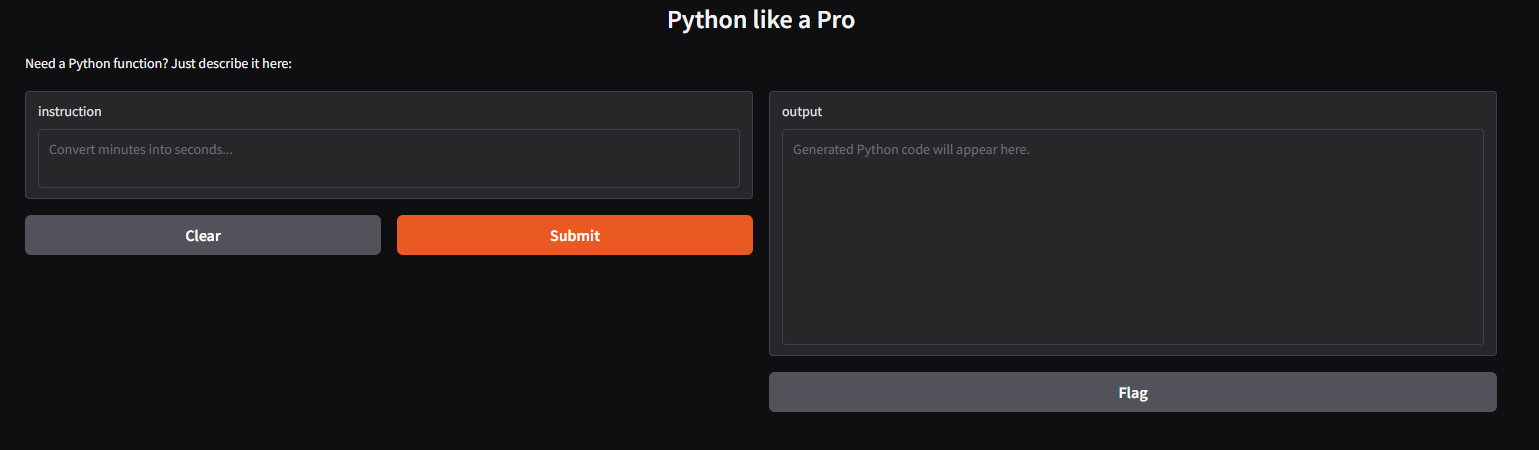

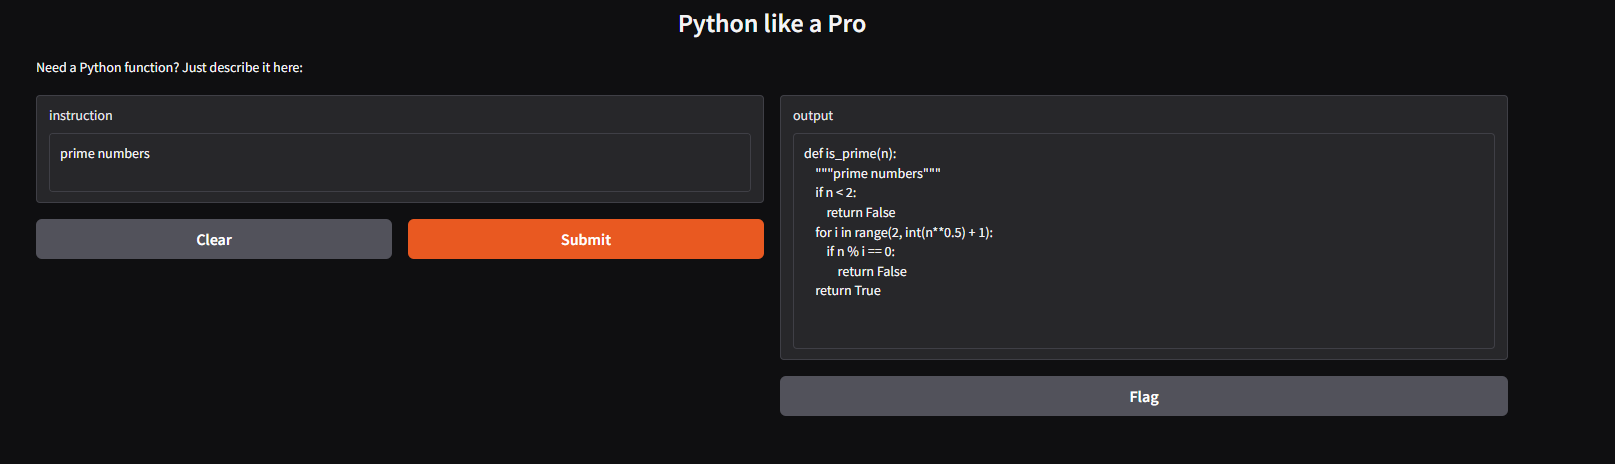

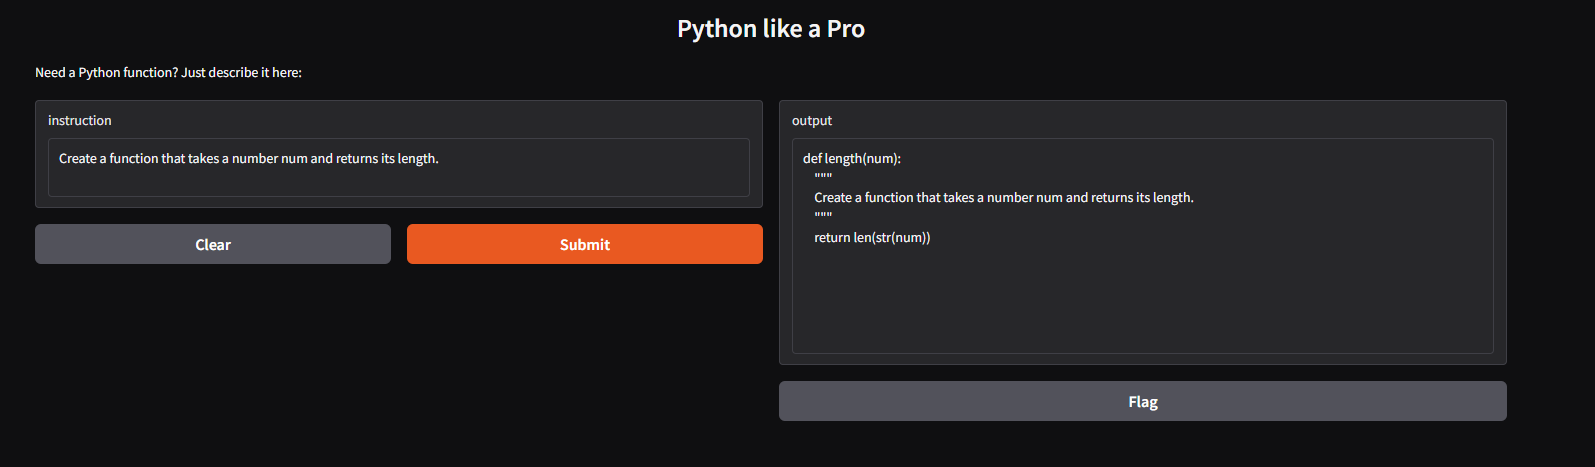

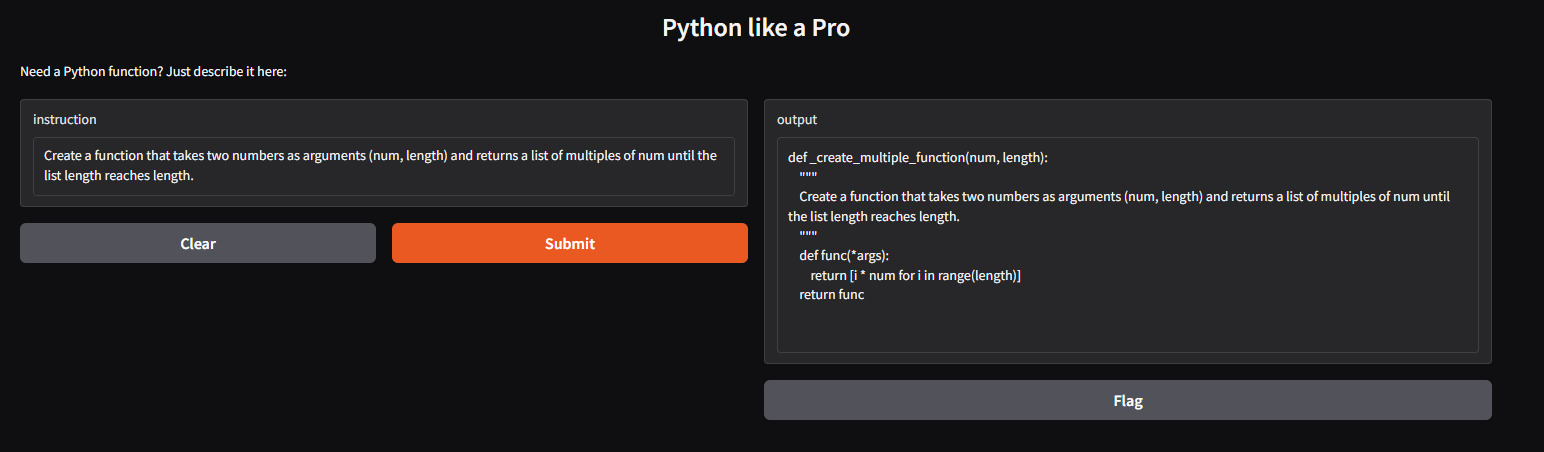

# ✅ **Crear repo en Huggingface**

In [ ]:
huggingface-cli login

In [ ]:
huggingface-cli repo create python-like-a-pro --type model

In [ ]:
git clone https://huggingface.co/karenwhiteg/python-like-a-pro

🔵 **Huggingface Models:**
https://huggingface.co/karenwhiteg/python-like-a-pro

🔴 **Huggingface Spaces:** https://huggingface.co/spaces/karenwhiteg/Python_Like_A_Pro

📗**Huggingface Dataset:**  https://huggingface.co/datasets/karenwhiteg/Python_Like_A_Pro

# ✅ **Interfaz con Gradio en Spaces de Hugging Face**

Respuestas entre 20-40 segs de espera, van flucutando un poco los tiempos.

In [ ]:
# app.py en huggingface spaces

import os
import warnings
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login

# --- Authentication ---
hf_token = os.getenv("HF_TOKEN")
if not hf_token:
    raise ValueError("HF_TOKEN not found in environment variables")
login(token=hf_token, add_to_git_credential=True)

# Configuration
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_num_threads(4)
warnings.filterwarnings("ignore")

# Load model
model_path = "karenwhiteg/Llama-3.2-1B-Instruct-pythonlikeapro"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float32,
    device_map="cpu"
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

def generate_code(instruction):
    instruction = instruction[:500]
    prompt = f"<|startoftext|>\n### Instruction:\nYou are a Senior Software Developer. Generate only Python code without explanations. Respond in English.\n\n### Task:\n{instruction}\n\n### Response:\n"

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=384,
        truncation=True,
        padding="max_length"
    ).to(model.device)

    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            temperature=0.7,
            num_beams=2,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded.replace(prompt, "").split("<|endoftext|>")[0].strip()

# Create interface
interface = gr.Interface(
    fn=generate_code,
    inputs=gr.Textbox(
        lines=2,
        placeholder="How can I convert minutes into seconds?...",
        max_lines=2
    ),
    outputs=gr.Textbox(
        lines=10,
        placeholder="Generated Python code will appear here.",
        label="Generated Code"
    ),
    title="Python like a Pro",
    description="Need a Python function? Just describe it here:",
    allow_flagging="never"
)

# Launch with queuing enabled
if __name__ == "__main__":
    interface.queue()  # Enable queuing here
    interface.launch(
        server_name="0.0.0.0",
        server_port=7860
    )

## ❓ ❔ **Example questions**


"Write a Python function to convert minutes to seconds"

"Create a function to check if a number is even or odd"

"Write code to reverse a string"

"Create a function to find the max value in a list"

"Write code to merge two dictionaries"

"Implement a binary search algorithm"

"Write a function to check if a number is prime"

"Create code to count lines in a text file"

"Write code to download webpage content"

"Write a decorator to measure function execution time"

"Create a generator function for Fibonacci sequence"

"Implement a Rectangle class with area calculation"

"Write async code to fetch multiple URLs concurrently"

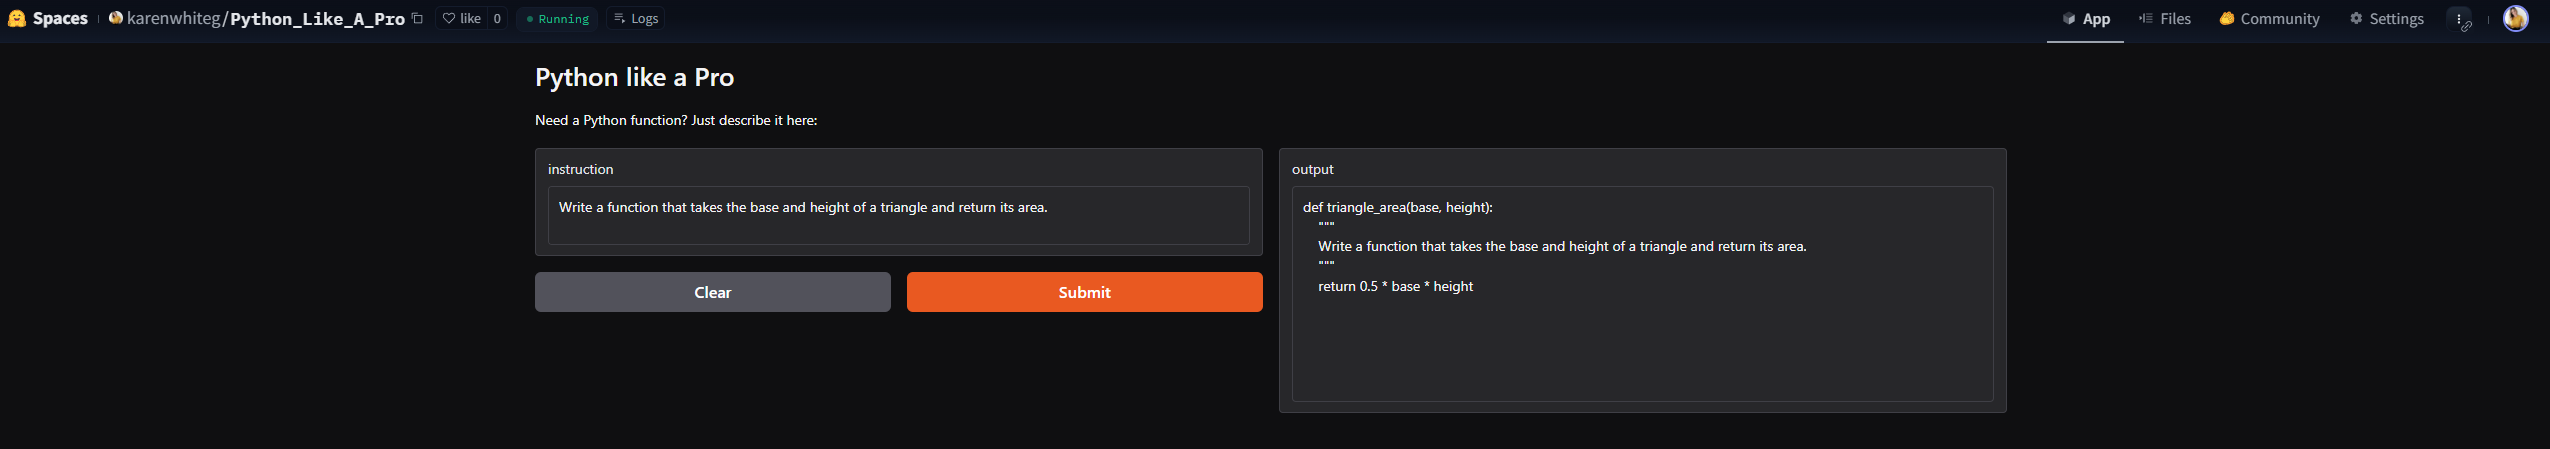

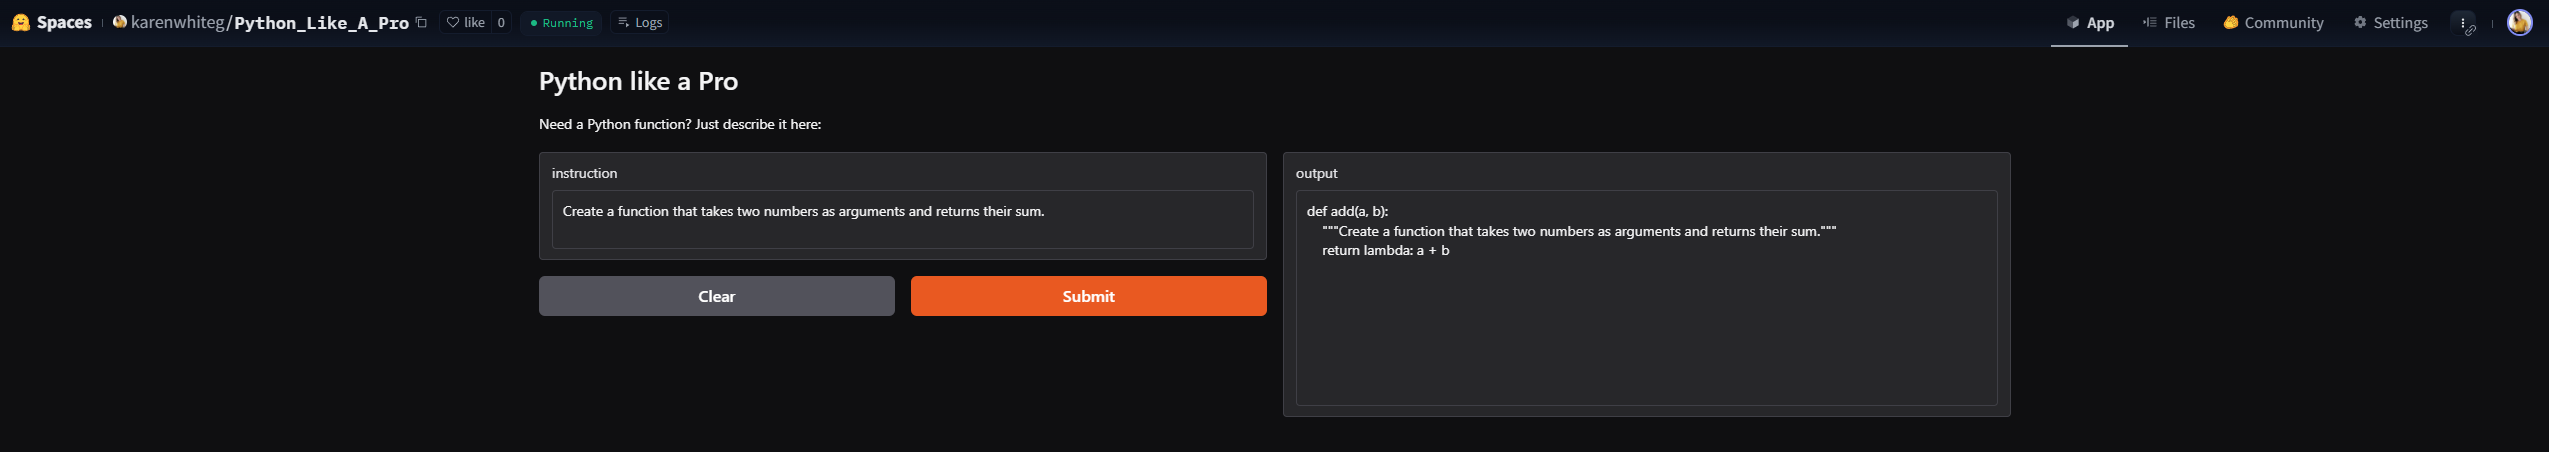

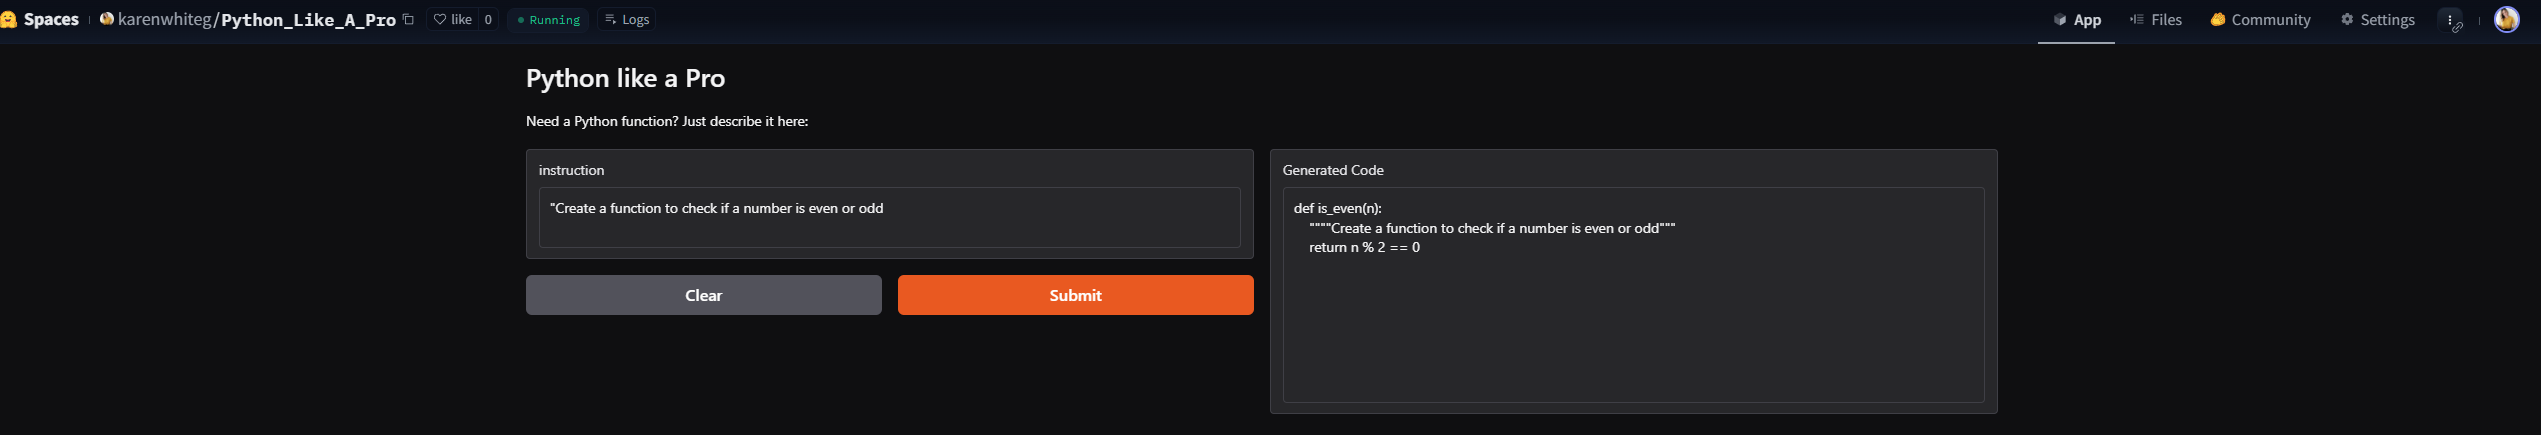